#  Learn Modulation and Demodulation in Nonlinear Channels with Deep Neural Networks by Autoencoders and End-to-end Training

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* End-to-end-learning of modulation scheme and demodulator in a simple nonlinear channel model with time-varying batch size
* Reinforcement Learning using policy learning (policy gradient method)

This code is based on the the following paper:
* Fayçal Ait Aoudia, Jakob Hoydis, "End-to-End Learning of Communications Systems Without a Channel Model" (https://arxiv.org/pdf/1804.02276.pdf).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


### Define Transmitter, Channel, Recevier and helper functions

This is the main neural network/Autoencoder with transmitter, channel and receiver. Transmitter and receiver each with ELU activation function. Note that the final layer does *not* use a `softmax` function, as this function is already included in the `CrossEntropyLoss`. <br>

In [2]:
class Transmitter(nn.Module):
    def __init__(self):
        super(Transmitter, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        # the matrix defines just a mapping between one-hot vectors and modulation symbols
        # Use Xavier initialization
        self.W = nn.Parameter(torch.empty(M,2))
        nn.init.xavier_uniform_(self.W)
        
    # Normalize channel input
    def normalize(self, x, P_in_lin):
        norm_factor = torch.mean(torch.sqrt(torch.sum(torch.square(x), 1)))/np.sqrt(P_in_lin)
        return norm_factor
    
    # Transmitter function, just a modulation followed by normalization
    def forward(self, x, P_in_lin):
        # compute output
        norm_factor = self.normalize(self.W, P_in_lin)
        out = torch.matmul(x, self.W/norm_factor)
        return out
        
    
class Receiver(nn.Module):
    def __init__(self, hidden_neurons_RX):
        super(Receiver, self).__init__()
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.fcR1 = nn.Linear(2,hidden_neurons_RX[0]) 
        self.fcR2 = nn.Linear(hidden_neurons_RX[0], hidden_neurons_RX[1]) 
        self.fcR3 = nn.Linear(hidden_neurons_RX[1], hidden_neurons_RX[2]) 
        self.fcR4 = nn.Linear(hidden_neurons_RX[2], M) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()      

    # Receiver neural network    
    def forward(self, x):
        out = self.activation_function(self.fcR1(x))
        out = self.activation_function(self.fcR2(out))
        out = self.activation_function(self.fcR3(out))
        logits = self.fcR4(out)
        return logits    

In [3]:
# Optical fiber channel model
def channel_model(x, L, Kstep, gamma):
    # simulate the channel
    for i in range(Kstep):
        power = torch.norm(x, dim=1) ** 2
        rotcoff = (L / Kstep) * gamma * power

        # rotation matrix corresponding to exp(1j*rotcoff)        
        temp = torch.stack([x[:,0] * torch.cos(rotcoff) - x[:,1]*torch.sin(rotcoff), x[:,0]*torch.sin(rotcoff)+x[:,1]*torch.cos(rotcoff)], dim=1)        
        x = torch.add(temp, sigma_n*torch.randn(len(x),2).to(device))
    return x

In [4]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

### Parameter and Training
Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [5]:
# number of symbols
M = 16

P_in_dBm = 6 # 6dBm input power
P_in_lin = 10**((P_in_dBm-30)/10)

SNR = 17 # dB

# channel parameter
L = 500                                                 # in [km]
gamma = 1.27                                            # Nonlinear Kerr-Coefficient in [W/km]
Kstep = 50 # number of steps used in the channel model
# noise variance per step   
sigma_n = np.sqrt(P_in_lin* 10**(-SNR/10) / Kstep / 2)

# validation set. Training examples are generated on the fly
N_valid = 100000

# variance of policy vector
sigma_p = np.sqrt(0.02*P_in_lin)

# number of neurons in hidden layers at receiver
hidden_neurons_RX_1 = 50
hidden_neurons_RX_2 = 50
hidden_neurons_RX_3 = 50
hidden_neurons_RX = [hidden_neurons_RX_1, hidden_neurons_RX_2, hidden_neurons_RX_3]

# Generate Validation Data
y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]

# meshgrid for plotting
# assume that the worst case constellation is the one where all points lie on a straight line starting at the center and then are spreaded equidistantly. In this case, this is the scaling factor of the constellation points and we assume that there is an (M+1)th point which defines ext_max 
ext_max = 1.8*np.sqrt(P_in_lin)
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,400), np.linspace(-ext_max,ext_max,400))
meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1))))

Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

First, we train the receiver for a given transmitter. Then we calculate per-example-losses and use the policy gradient method to find the coefficients of the transmitter for a given receiver.

In [6]:
model_tx = Transmitter()
model_tx.to(device)

model_rx = Receiver(hidden_neurons_RX)
model_rx.to(device)

softmax = nn.Softmax(dim=1)

# Cross Entropy loss for RX-optimization
loss_fn = nn.CrossEntropyLoss()
loss_tx = nn.CrossEntropyLoss(reduction='none')


# Adam Optimizers for TX and RX
optimizer_tx = optim.Adam(model_tx.parameters(), lr=1e-3)  
optimizer_rx = optim.Adam(model_rx.parameters(), lr=1e-2)

# Training parameters
num_epochs = 120
batches_per_epoch = 100

# Vary batch size during training
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=np.int16)

validation_SERs = np.zeros(num_epochs)
validation_received = []
decision_region_evolution = []
constellations = []


print('Start Training')
for epoch in range(num_epochs):
       
    batch_labels = torch.empty(batch_size_per_epoch[epoch], device=device)

    # Optimize Receiver for a given transmitter, standard learning of the receiver parameters
    for step in range(batches_per_epoch):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        # Propagate (training) data through the net
        encoded = model_tx(batch_labels_onehot, P_in_lin)
                
        # channel model
        received = channel_model(encoded, L, Kstep, gamma)
        
        # receiver
        logits = model_rx(received)

        # compute loss
        loss = loss_fn(logits, batch_labels.long())

        # compute gradients
        loss.backward()
        
        # Adapt weights
        optimizer_rx.step()
        
        # reset gradients
        optimizer_rx.zero_grad()

        
    # Optimize Transmitter using the policy gradient method
    for step in range(batches_per_epoch):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        # Propagate (training) data through the net
        tx_output = model_tx(batch_labels_onehot, P_in_lin)
        
        # apply policy, which is Gaussian noise
        noise = (sigma_p / np.sqrt(2)) * torch.randn_like(tx_output).to(device)               
        encoded = np.sqrt(1-(sigma_p**2))*tx_output.detach() + noise      
          
        # channel model
        encoded_clone = encoded.clone().detach()
        received = channel_model(encoded_clone, L, Kstep, gamma)
        
        logits = model_rx(received)
        
        # compute per example losses ... detach from graph so that the gradient is not computed        
        per_example_losses = loss_tx(logits, batch_labels.long()).clone().detach()
        
        # policy gradient loss
        pg_loss = (1/batch_size_per_epoch[epoch])*torch.sum(
            per_example_losses * torch.log(
                (1/(np.pi * sigma_p**2))*torch.exp(-1/(sigma_p**2)*torch.sum(torch.square(
                    encoded_clone-np.sqrt(1-(sigma_p**2))*tx_output), 1)
                )
            )
        )   
        
        # compute gradients
        pg_loss.backward()
        
        # Adapt weights
        optimizer_tx.step()
        
        # reset gradients
        optimizer_tx.zero_grad()
        
        
    # compute validation SER
    with torch.no_grad():
        encoded_valid = model_tx(torch.Tensor(y_valid_onehot).to(device),P_in_lin)
        received_valid = channel_model(encoded_valid, L, Kstep, gamma)
        out_valid = softmax(model_rx(received_valid))
        validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy().squeeze(), y_valid)
        print('Validation SER after epoch %d: %f (loss %1.8f, pg_loss %1.8f)' % (epoch, validation_SERs[epoch], loss.detach().cpu().numpy(), pg_loss.detach().cpu().numpy()))                

        # calculate and store received validation data
        encoded = model_tx(torch.Tensor(y_valid_onehot).to(device),P_in_lin)
        received = channel_model(encoded, L, Kstep, gamma)
        validation_received.append(received.detach().cpu().numpy())

        # calculate and store constellation
        encoded = model_tx(torch.eye(M).to(device),P_in_lin)
        constellations.append(encoded.detach().cpu().numpy())

        # store decision region for generating the animation
        mesh_prediction = softmax(model_rx(torch.Tensor(meshgrid).to(device)))
        decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)
    
print('Training finished')
print(model_tx.W)

Start Training
Validation SER after epoch 0: 0.252970 (loss 0.72642332, pg_loss 14.92122078)
Validation SER after epoch 1: 0.171970 (loss 0.54748905, pg_loss 14.51635838)
Validation SER after epoch 2: 0.141000 (loss 0.38318112, pg_loss 8.61919689)
Validation SER after epoch 3: 0.142220 (loss 0.36128750, pg_loss 8.15781975)
Validation SER after epoch 4: 0.135970 (loss 0.26645207, pg_loss 7.06605005)
Validation SER after epoch 5: 0.120370 (loss 0.26121619, pg_loss 10.16152859)
Validation SER after epoch 6: 0.124250 (loss 0.23725432, pg_loss 8.46613026)
Validation SER after epoch 7: 0.113030 (loss 0.23719841, pg_loss 6.77508545)
Validation SER after epoch 8: 0.113530 (loss 0.26895651, pg_loss 6.98417044)
Validation SER after epoch 9: 0.105960 (loss 0.25722507, pg_loss 6.63412333)
Validation SER after epoch 10: 0.105610 (loss 0.22990055, pg_loss 6.48111725)
Validation SER after epoch 11: 0.101080 (loss 0.21878432, pg_loss 6.68194485)
Validation SER after epoch 12: 0.098390 (loss 0.18650480

Validation SER after epoch 105: 0.039800 (loss 0.10770185, pg_loss 4.29549313)
Validation SER after epoch 106: 0.040850 (loss 0.10618494, pg_loss 4.13391495)
Validation SER after epoch 107: 0.042550 (loss 0.10597027, pg_loss 4.28672934)
Validation SER after epoch 108: 0.041880 (loss 0.10748333, pg_loss 4.15152550)
Validation SER after epoch 109: 0.041980 (loss 0.11367940, pg_loss 4.12118864)
Validation SER after epoch 110: 0.041620 (loss 0.10433889, pg_loss 4.26844931)
Validation SER after epoch 111: 0.040960 (loss 0.11059269, pg_loss 4.11457586)
Validation SER after epoch 112: 0.041560 (loss 0.11058690, pg_loss 4.21547461)
Validation SER after epoch 113: 0.039430 (loss 0.11201237, pg_loss 3.90708876)
Validation SER after epoch 114: 0.041000 (loss 0.10515636, pg_loss 4.09803343)
Validation SER after epoch 115: 0.039470 (loss 0.10729159, pg_loss 4.06426096)
Validation SER after epoch 116: 0.038710 (loss 0.10039364, pg_loss 4.11216688)
Validation SER after epoch 117: 0.038700 (loss 0.102

### Evaluation
Plot decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing SERs and plotting, there is no feedback towards the training!

In [7]:
# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)
print('Minimum SER obtained: %1.5f' % validation_SERs[min_SER_iter])

ext_max_plot = 1.05*max(max(abs(validation_received[min_SER_iter][:,0])), max(abs(validation_received[min_SER_iter][:,1])))

Minimum SER obtained: 0.03574


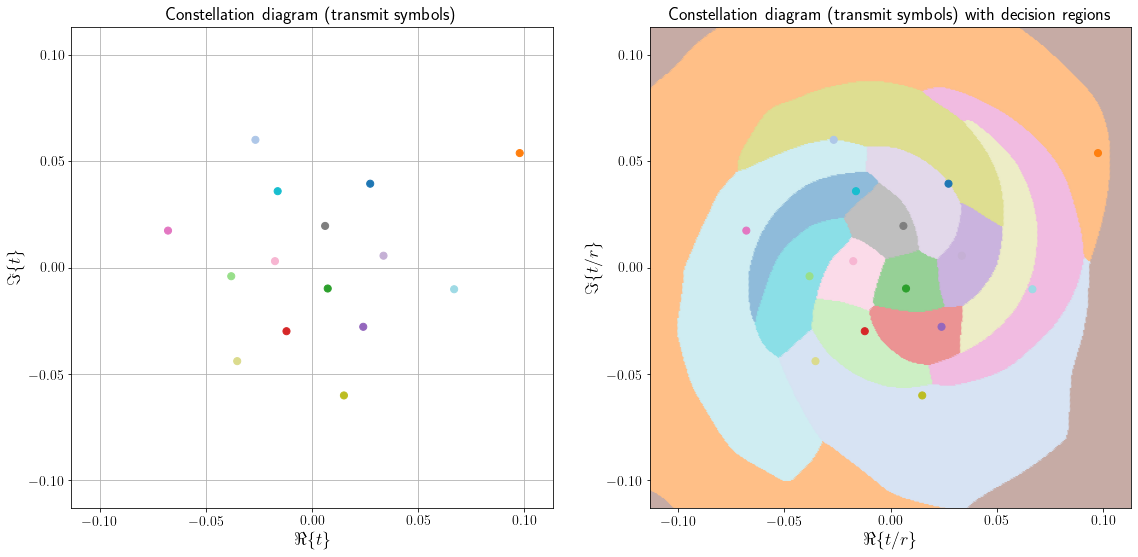

In [13]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

%matplotlib inline
plt.figure(figsize=(19,9.5))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    
plt.subplot(121)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{t\}$',fontsize=18)
plt.ylabel(r'$\Im\{t\}$',fontsize=18)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.grid(which='both')
plt.title('Constellation diagram (transmit symbols)',fontsize=18)

plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{t/r\}$',fontsize=18)
plt.ylabel(r'$\Im\{t/r\}$',fontsize=18)
plt.title('Constellation diagram (transmit symbols) with decision regions',fontsize=18)


plt.savefig('PGAE_Optical_NN_M%d_Pin%1.2f_SNR%1.2f_const.pdf' % (M,P_in_dBm,SNR),bbox_inches='tight')

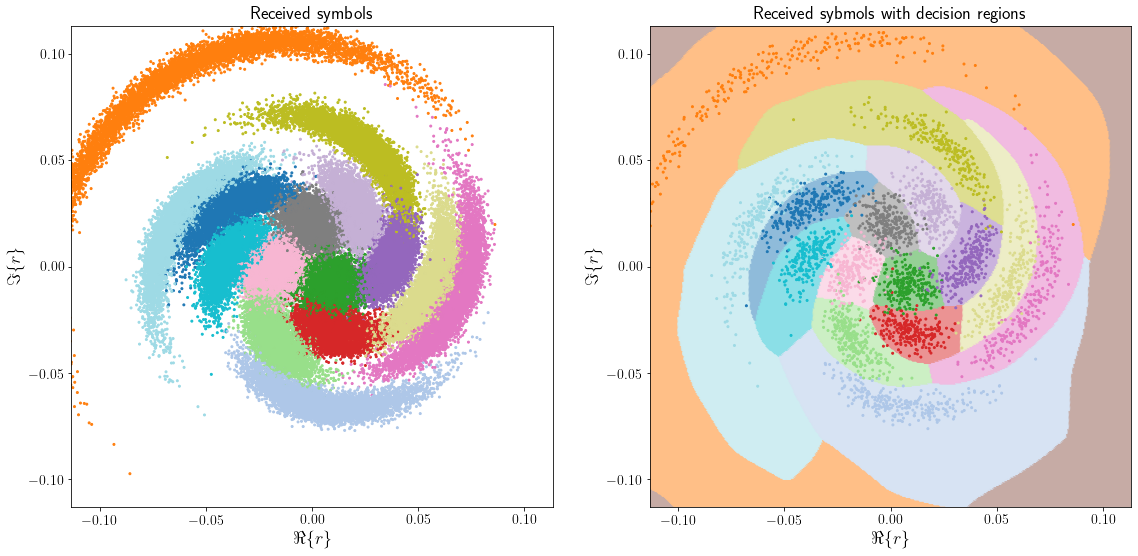

In [11]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

%matplotlib inline
plt.figure(figsize=(19,9.5))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    

plt.subplot(121)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_SER_iter][:,0], validation_received[min_SER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=18)
plt.ylabel(r'$\Im\{r\}$',fontsize=18)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.title('Received symbols',fontsize=18)

plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(validation_received[min_SER_iter][0:4000,0], validation_received[min_SER_iter][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=18)
plt.ylabel(r'$\Im\{r\}$',fontsize=18)
plt.title('Received sybmols with decision regions',fontsize=18)

plt.savefig('PGAE_Optical_NN_M%d_Pin%1.2f_SNR%1.2f_noisy.pdf' % (M,P_in_dBm,SNR),bbox_inches='tight')

<IPython.core.display.Javascript object>


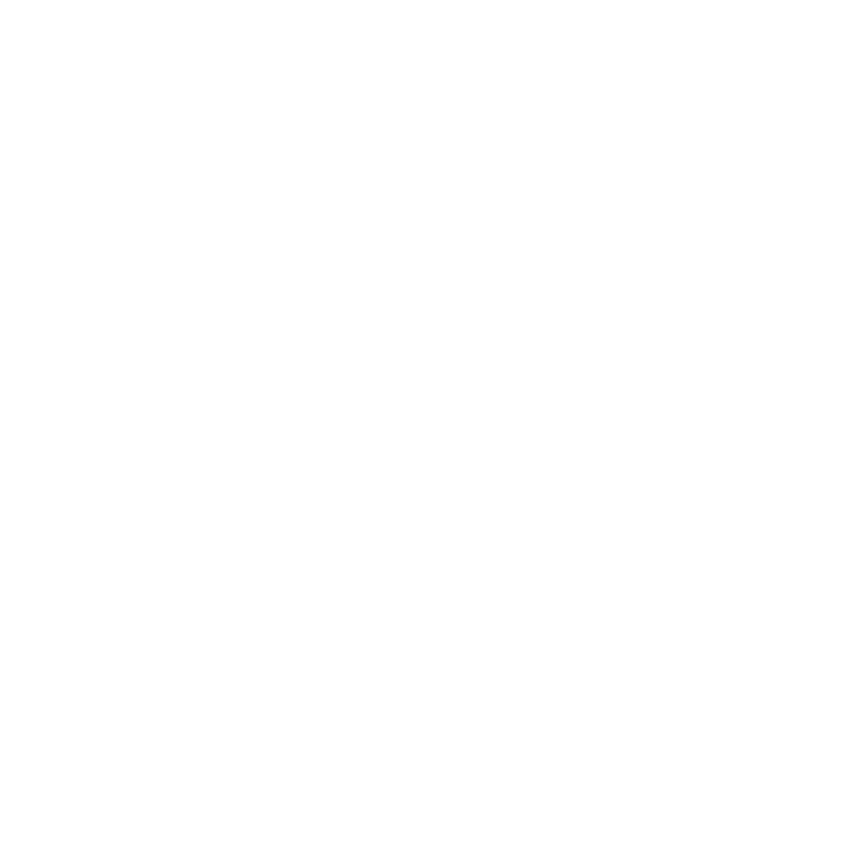

<IPython.core.display.Javascript object>


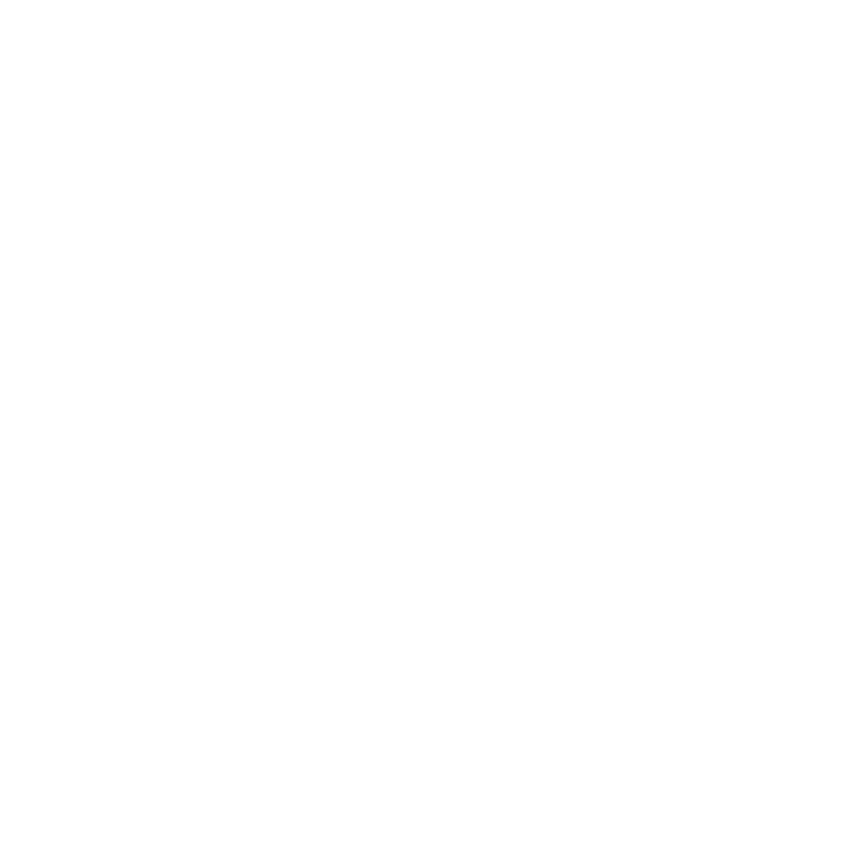

Traceback (most recent call last):
  File "/home/simulation/MLenv/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/simulation/MLenv/lib64/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [14]:
%matplotlib notebook
%matplotlib notebook

cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.axis('scaled')

written = True
def animate(i):
    ax.clear()
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    
    ax.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    ax.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=50)
    ax.scatter(validation_received[i][0:4000,0], validation_received[i][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
    ax.set_xlim(( -ext_max, ext_max))
    ax.set_ylim(( -ext_max, ext_max))

    ax.set_xlabel(r'$\Re\{r\}$',fontsize=18)
    ax.set_ylabel(r'$\Im\{r\}$',fontsize=18)

anim = animation.FuncAnimation(fig, animate, frames=num_epochs-1, interval=200, blit=False)
plt.show()
anim.save('PGAE_Optical_NN_M%d_Pin%1.2f_SNR%1.2f_anim.gif' % (M,P_in_dBm,SNR), writer=PillowWriter(fps=5))